In [4]:
## python
import os
import random
import sys

## package
import glob
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

## keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import History, ReduceLROnPlateau, CSVLogger
from keras.models   import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

##SkLearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pyLab inline

In [5]:
os.getcwd()     #looking for the file in inthe working directory
print(os.listdir())

['.ipynb_checkpoints', 'Audio_Speech_Actors_01-24', 'model', 'model.json', 'output10.wav', 'Predictions.csv', 'saved_models', 'Untitled.ipynb']


In [6]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('Audio_Speech_Actors_01-24/') #Data in the directory
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [7]:
#Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('Audio_Speech_Actors_01-24' + '/'+i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'Audio_Speech_Actors_01-24'+'/' + i +'/'+f    #The file name has been accordingly to the data it represent
        src = int(nm[1])                                     #Those datas are convert to data frame
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [8]:
print (len(data_df))  #check the number of rows in the data frame
data_df.head()        #use to see the first 5 rows of the data frame

2452


,path,source,actor,gender,intensity,statement,repetition,emotion
0,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,0,1
1,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,1,1
2,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,0,1
3,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,1,1
4,Audio_Speech_Actors_01-24/Actor_01/03-01-02-01...,1,1,male,0,0,0,2


# Plotting the audio file's waveform and its spectrogram

In [9]:
filename = data_df.path[1021]    #10 data
print (filename)                                

samples, sample_rate = librosa.load(filename)
sample_rate, samples

Audio_Speech_Actors_01-24/Actor_10/03-02-04-02-01-02-10.wav


(22050,
 array([-3.4990700e-04, -2.1845367e-04,  5.5546162e-04, ...,
        -9.7345328e-06, -3.8411690e-05,  0.0000000e+00], dtype=float32))

In [10]:
len(samples), sample_rate

(112568, 22050)

In [11]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3)) #1e3 represent 1000
    noverlap = int(round(step_size * sample_rate / 1e3))               
    freqs, times, spec = signal.spectrogram(audio,       
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [12]:
sample_rate/ len(samples)

0.19588160045483619

Text(0.5, 0, 'Seconds')

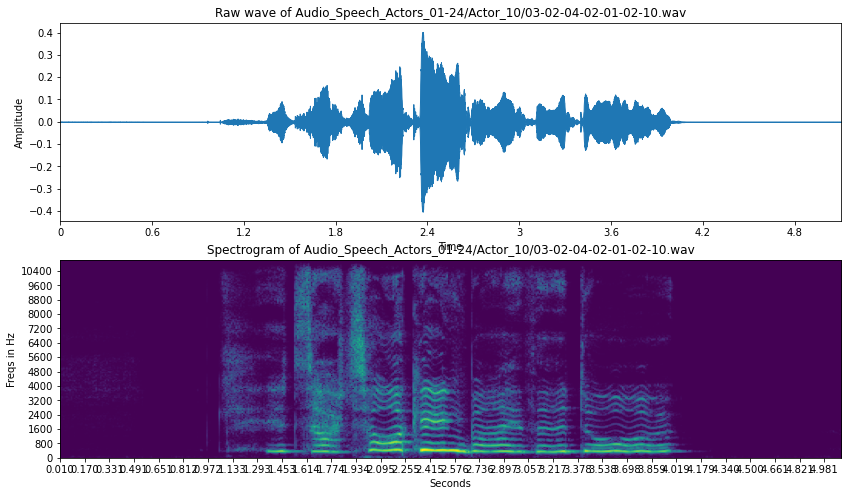

In [13]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))#fig size :specify the width and height
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)             #plotting wave Form and spectrogram

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [14]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std


In [15]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)   
aa, bb

(array([-0.00037444, -0.00035654, -0.0005744 , ..., -0.0013954 ,
        -0.00090462, -0.00053319], dtype=float32),
 array([29184, 88576]))

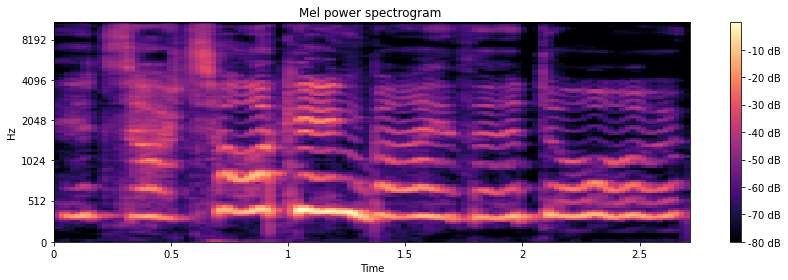

In [16]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.    #ploting Mel power spectrogram
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

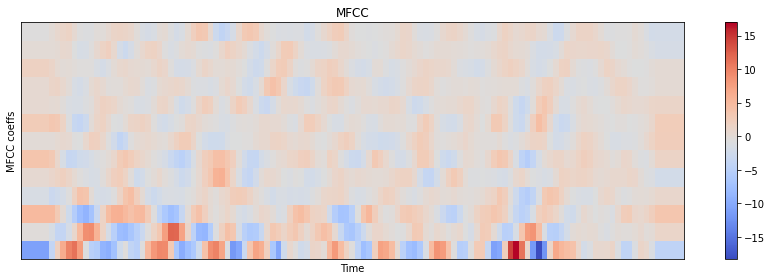

In [17]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [18]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [19]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [20]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# Defining the truth label

In [21]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)


2452

In [22]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

2452

In [23]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

2452

In [24]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)


2452

In [25]:
# Select the label set you want by commenting the unwanteds.

#data_df['label'] = label2_list # 
#data_df['label'] = label3_list
#data_df['label'] = label5_list
data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,0,1,male_neutral
1,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,1,1,male_neutral
2,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,0,1,male_neutral
3,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,1,1,male_neutral
4,Audio_Speech_Actors_01-24/Actor_01/03-01-02-01...,1,1,male,0,0,0,2,male_calm


In [26]:
print (data_df.label.value_counts().keys())

Index(['male_happy', 'male_calm', 'male_sad', 'male_angry', 'male_fearful',
       'female_calm', 'female_happy', 'female_sad', 'female_angry',
       'female_fearful', 'male_neutral', 'male_disgust', 'female_disgust',
       'female_surprised', 'male_surprised', 'female_neutral'],
      dtype='object')


In [27]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


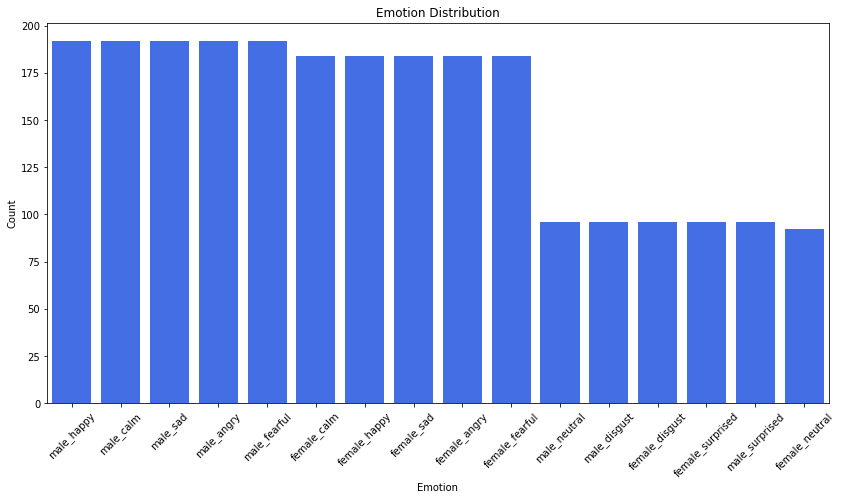

In [28]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")


In [29]:
# Female Data Set

## Uncomment all below to use Female set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
data2_df = data2_df[data2_df.label != "male_happy"]
data2_df = data2_df[data2_df.label != "male_angry"]
data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 22]
tmp2 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

1284


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,0,1,male_neutral
1,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,1,1,male_neutral
2,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,0,1,male_neutral
3,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,1,1,male_neutral
4,Audio_Speech_Actors_01-24/Actor_01/03-01-07-01...,1,1,male,0,0,0,7,male_disgust


In [30]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

1200


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,0,1,male_neutral
1,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,0,1,1,male_neutral
2,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,0,1,male_neutral
3,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,1,1,male,0,1,1,1,male_neutral
4,Audio_Speech_Actors_01-24/Actor_01/03-01-02-01...,1,1,male,0,0,0,2,male_calm


In [31]:
print (len(data3_df))
data3_df.head()

208


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,Audio_Speech_Actors_01-24/Actor_21/03-01-01-01...,1,21,male,0,0,0,1,male_neutral
1,Audio_Speech_Actors_01-24/Actor_21/03-01-01-01...,1,21,male,0,0,1,1,male_neutral
2,Audio_Speech_Actors_01-24/Actor_21/03-01-01-01...,1,21,male,0,1,0,1,male_neutral
3,Audio_Speech_Actors_01-24/Actor_21/03-01-01-01...,1,21,male,0,1,1,1,male_neutral
4,Audio_Speech_Actors_01-24/Actor_21/03-01-02-01...,1,21,male,0,0,0,2,male_calm


# Getting the features of audio files using librosa

In [32]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [03:29<00:00,  5.74it/s]


In [33]:
data.head()

,feature
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-61.84994, -62.89504, -63.830635, -60.552586,..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."


In [34]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [35]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-70.267769,-69.95771,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769


In [36]:
newdf = pd.concat([df3,labels], axis=1)

In [37]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

1200

In [38]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_neutral
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm
5,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,-65.536194,-67.557388,-67.557388,...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.126572,-67.557388,male_calm
6,-69.673286,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.693306,-69.620773,-69.693306,-68.906570,...,-69.693306,-69.693306,-69.693306,-69.693306,-69.383514,-69.693306,-69.693306,-69.693306,-69.693306,male_calm
7,-69.051399,-69.051399,-69.051399,-69.051399,-69.051399,-68.754860,-69.051399,-69.051399,-69.051399,-68.359085,...,-68.552094,-69.051399,-69.051399,-69.051399,-68.688614,-69.051399,NaN,NaN,NaN,male_calm
8,-73.841370,-73.841370,-73.841370,-73.719650,-73.841370,-73.841370,-73.841370,-73.303635,-72.806808,-73.841370,...,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,-73.841370,male_calm
9,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-57.185970,-61.188725,-67.108391,-67.508125,-66.245537,-68.733047,-69.243256,-69.243256,-69.243256,male_calm


In [39]:
rnewdf.isnull().sum().sum()

4470

In [40]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.95771,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm


# Data Augmentation

In [41]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

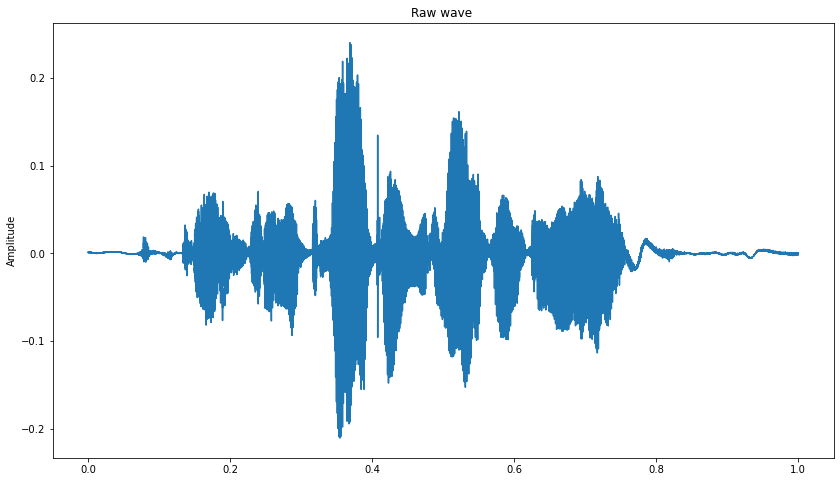

In [42]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

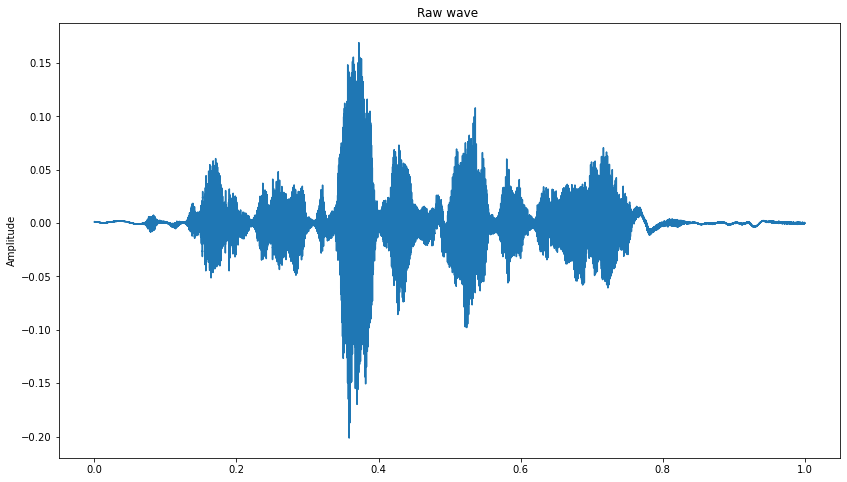

In [43]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)


In [44]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [03:05<00:00,  6.46it/s]


In [45]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [19:43<00:00,  1.01it/s]


In [46]:
len(syn_data1), len(syn_data2)


(1200, 1200)

In [47]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [48]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1200

In [49]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-56.250054,-56.111745,-57.441847,-58.823243,-58.733313,-57.269074,-57.685026,-59.489114,-58.539880,-59.077278,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,male_neutral
1,-56.489956,-56.220056,-55.644654,-54.779901,-55.256220,-55.851893,-56.768549,-59.675405,-60.487423,-61.183146,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,male_neutral
2,-61.254729,-60.267629,-61.018566,-59.269684,-59.601700,-61.069142,-61.167250,-58.554586,-59.636424,-61.965806,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,male_neutral
3,-54.840748,-52.187022,-51.204034,-51.067591,-49.579793,-50.158273,-51.593457,-49.732995,-50.012930,-49.866137,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,male_neutral
4,-59.015732,-58.066216,-57.040415,-57.546545,-57.353399,-57.221245,-59.818848,-57.405142,-56.359093,-59.421701,...,-57.39555,-58.120756,-56.423306,-56.454143,-58.509024,-58.405149,-56.744442,-56.12475,-57.844467,male_calm


In [50]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1200

In [51]:
syndf2.head()


,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.083457,-70.083457,-70.083457,-70.083457,-70.083457,-70.083457,-70.083457,-70.083457,-70.083457,-70.083457,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-62.112976,-63.671041,-65.345358,-64.026415,-63.921830,-65.523836,-66.950812,-67.732105,-67.732105,-67.732105,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-68.669426,-68.669426,-68.669426,-68.669426,-68.454781,-68.669426,-68.659458,-67.492127,-68.523612,-68.669426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-67.374316,-67.374316,-67.374316,-67.374316,-67.374316,-67.374316,-67.374316,-67.374316,-67.374316,-67.374316,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,...,-71.927229,-70.428519,-71.019709,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,-71.927229,male_calm


In [52]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
1,-61.849941,-62.895039,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,-65.389946,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
2,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,-65.818863,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
3,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_neutral
4,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-69.95771,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769,male_calm


In [53]:
#stratified shuffle split

from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)                       ####doubt
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X,y):
    X_train, X_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]

In [54]:
y_train.value_counts()

male_calm           384
male_fearful        384
male_happy          384
male_sad            384
male_angry          384
male_disgust        192
female_disgust      192
female_surprised    192
male_neutral        192
male_surprised      192
Name: label, dtype: int64

In [55]:
y_test.value_counts()

male_calm           96
male_sad            96
male_happy          96
male_angry          96
male_fearful        96
male_disgust        48
female_disgust      48
female_surprised    48
male_surprised      48
male_neutral        48
Name: label, dtype: int64

In [56]:
X_train.isna().sum().sum()

0

In [57]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [58]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [59]:
X_train.shape

(2880, 259)

# Changing dimension for CNN model

In [60]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [61]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [62]:
# New model
#model = Sequential()
#model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
#model.add(Activation('relu'))
#model.add(Conv1D(256, 8, padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=(8)))
#model.add(Conv1D(128, 8, padding='same'))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 8, padding='same'))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 8, padding='same'))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 8, padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=(8)))
#model.add(Conv1D(64, 8, padding='same'))
#model.add(Activation('relu'))
#model.add(Conv1D(64, 8, padding='same'))
#model.add(Activation('relu'))
#model.add(Flatten())
# Edit according to target class no.
#model.add(Dense(2))
#model.add(Activation('softmax'))
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [63]:
#model = Sequential()

#model.add(Conv1D(256, 5,padding='same',
                 #input_shape=(216,1)))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same'))
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(MaxPooling1D(pool_size=(8)))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Flatten())
#model.add(Dense(8))
#model.add(Activation('softmax'))
#opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
#optimizer = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=1e-6, nesterov=False)

In [64]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
#Edit according to target class no.
model.add(Dense(10))
model.add(Activation('softmax'))
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

C:\Users\94706\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [65]:
#Original Model

#model = Sequential()
#model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same'))
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(MaxPooling1D(pool_size=(8)))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu')) 
#model.add(Dropout(0.2))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Flatten())
#model.add(Dense(5))
#model.add(Activation('softmax'))
#opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
#opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

In [66]:
# Plotting Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 259, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 259, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 259, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 256)           0

In [67]:
# Compile your model

#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [68]:
#cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))


# Removed the whole training part for avoiding unnecessary long epochs list

In [69]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100
180/180 [==============================] - 109s 343ms/step - loss: 2.0413 - accuracy: 0.2510 - val_loss: 2.0235 - val_accuracy: 0.2819
Epoch 2/100
180/180 [==============================] - 60s 334ms/step - loss: 1.7321 - accuracy: 0.3525 - val_loss: 1.8587 - val_accuracy: 0.3208
Epoch 3/100
180/180 [==============================] - 58s 322ms/step - loss: 1.5856 - accuracy: 0.4242 - val_loss: 1.7665 - val_accuracy: 0.3486
Epoch 4/100
180/180 [==============================] - 59s 326ms/step - loss: 1.4929 - accuracy: 0.4527 - val_loss: 1.5838 - val_accuracy: 0.3847
Epoch 5/100
180/180 [==============================] - 67s 373ms/step - loss: 1.3273 - accuracy: 0.5156 - val_loss: 1.6611 - val_accuracy: 0.3653
Epoch 6/100
180/180 [==============================] - 69s 384ms/step - loss: 1.2532 - accuracy: 0.5526 - val_loss: 1.6354 - val_accuracy: 0.3958
Epoch 7/100
180/180 [==============================] - 63s 353ms/step - loss: 1.1279 - accuracy: 0.6020 - val_loss: 1.4325 

Epoch 57/100
180/180 [==============================] - 46s 255ms/step - loss: 0.0118 - accuracy: 0.9981 - val_loss: 0.4130 - val_accuracy: 0.8861
Epoch 58/100
180/180 [==============================] - 50s 275ms/step - loss: 0.0117 - accuracy: 0.9955 - val_loss: 0.6457 - val_accuracy: 0.8222
Epoch 59/100
180/180 [==============================] - 46s 258ms/step - loss: 0.0188 - accuracy: 0.9929 - val_loss: 0.6521 - val_accuracy: 0.8264
Epoch 60/100
180/180 [==============================] - 47s 262ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.3789 - val_accuracy: 0.8944
Epoch 61/100
180/180 [==============================] - 47s 263ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.3842 - val_accuracy: 0.8861
Epoch 62/100
180/180 [==============================] - 47s 262ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.5266 - val_accuracy: 0.8528
Epoch 63/100
180/180 [==============================] - 48s 267ms/step - loss: 0.0107 - accuracy: 0.9959 - val_loss: 0

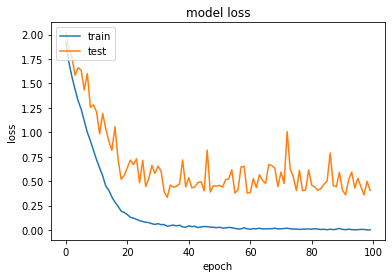

In [105]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Saving the model

In [106]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [107]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\94706\Emotion_Detector_FINALOUTPUT\saved_models\Emotion_Voice_Detection_Model.h5 


In [108]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Loading the model

In [109]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 89.44%


In [110]:
len(data3_df)

208

In [111]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)                                     
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:13<00:00, 14.96it/s]


In [112]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

13/13 [==============================] - 2s 63ms/step


In [113]:
preds

array([[3.7227974e-11, 4.1644292e-12, 2.1315518e-06, ..., 1.9973162e-07,
        8.8711087e-05, 4.4795466e-03],
       [2.3628939e-08, 1.0708816e-12, 5.9184990e-06, ..., 2.9864534e-08,
        1.0758968e-04, 9.9501907e-05],
       [8.4504913e-14, 1.9128199e-08, 1.9338106e-06, ..., 6.6351260e-12,
        2.3563075e-04, 1.0835423e-04],
       ...,
       [1.9847548e-06, 9.0849335e-06, 3.3888433e-03, ..., 1.3899656e-08,
        9.3246543e-01, 1.4830781e-07],
       [7.4953425e-11, 5.7806560e-09, 3.1031714e-06, ..., 1.2511644e-04,
        1.0356391e-03, 1.0111859e-06],
       [2.1830768e-08, 1.5987757e-07, 1.4185599e-06, ..., 8.7449476e-03,
        8.3005562e-04, 7.6061915e-06]], dtype=float32)

In [114]:
preds1=preds.argmax(axis=1)

In [115]:
preds1

array([4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 9, 9, 2, 2, 2, 6, 3, 3,
       4, 3, 5, 5, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 5, 5, 5, 5, 8, 5,
       4, 4, 9, 4, 4, 3, 4, 2, 6, 0, 0, 6, 5, 5, 0, 2, 7, 5, 0, 6, 7, 7,
       8, 8, 8, 8, 2, 8, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 3, 8, 8, 8, 8,
       2, 6, 2, 6, 6, 2, 2, 2, 6, 5, 6, 2, 5, 6, 8, 7, 8, 4, 5, 8, 3, 8,
       5, 5, 8, 3, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 5, 4, 5, 5, 5, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 5, 4, 4, 0, 0, 4, 4,
       4, 4, 0, 0, 0, 0, 6, 0, 0, 0, 7, 7, 7, 7, 8, 7, 6, 7, 3, 8, 8, 8,
       7, 7, 7, 7, 7, 7, 5, 5, 8, 8, 8, 8, 8, 8, 3, 8, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 5, 6, 8, 8, 8, 5, 5], dtype=int64)

In [116]:
#abc = preds1.astype(int).flatten()

In [117]:
#predictions = (lb.inverse_transform((abc)))

In [118]:
##preddf = pd.DataFrame({'predictedvalues': predictions})
##preddf[:10]

In [119]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [120]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_neutral
1,male_neutral
2,male_neutral
3,male_neutral
4,male_calm
5,male_calm
6,male_calm
7,male_calm
8,male_calm
9,male_calm


In [121]:
#finaldf = actualdf.join(preddf)

In [122]:
##finaldf[20:40]

In [123]:
#finaldf.groupby('actualvalues').count()

In [124]:
#finaldf.groupby('predictedvalues').count()

In [125]:
#finaldf.to_csv('Predictions.csv', index=False)

In [126]:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()


* recording
* done recording


In [127]:
data, sampling_rate = librosa.load('output10.wav')

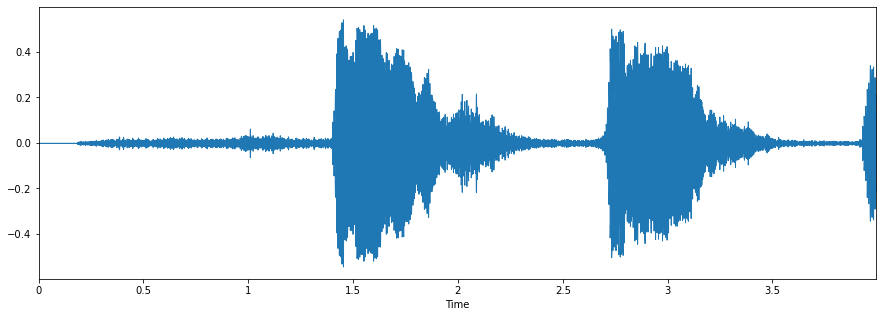

In [128]:
#% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [129]:
#data = pd.DataFrame(columns=['feature'])
#for i in tqdm(range(len(data2_df))):
    #X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
     #X = X[10000:90000]
    #sample_rate = np.array(sample_rate)
    #mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    #feature = mfccs
    #data.loc[i] = [feature]

In [130]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [131]:
livedf2= pd.DataFrame(data=livedf2)

In [132]:
livedf2 = livedf2.stack().to_frame().T

In [133]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.280636,-18.394176,-19.575983,-20.101147,-19.610579,-18.600859,-18.599607,-18.931133,-17.669189,-17.730265,...,-10.708151,-11.981853,-14.288697,-15.754357,-16.262905,-15.574909,-14.862172,-13.880698,-14.772884,-14.436692


In [134]:
twodim= np.expand_dims(livedf2, axis=2)

In [135]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 1s 961ms/step


In [136]:
livepreds

array([[2.2678344e-06, 3.7299276e-06, 6.7584656e-02, 1.2234405e-05,
        3.0008589e-06, 8.7207807e-03, 9.2129749e-01, 3.4025920e-06,
        2.3109023e-03, 6.1428371e-05]], dtype=float32)

In [137]:
livepreds1=livepreds.argmax(axis=1)

In [138]:
liveabc = livepreds1.astype(int).flatten()

In [139]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_sad'], dtype=object)